In [ ]:
import tensorflow as tf
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    Input,
    Flatten,
    Dense,
    Lambda,
    Reshape,
    Dot,
    Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D


# **Loading the Dataset**

In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Normalizing
X_train = X_train.astype('float32')
X_train /= 255
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.astype('float32')
X_test /= 255
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [ ]:
print("Shape of training data:")
print(X_train.shape)
print(Y_train.shape)

print("Shape of test data:")
print(X_test.shape)
print(Y_test.shape)

Shape of training data:
(60000, 784)
(60000,)
Shape of test data:
(10000, 784)
(10000,)


# **Making Pairs for One Shot Learning**

In [ ]:
class Pairs:
    def makePairs(self, x, y):
        num_classes = 10

        digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

        pairs = []
        labels = []

        n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1

        for d in range(num_classes):
            for i in range(n):
                z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
                pairs.append([x[z1], x[z2]])

                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                z1, z2 = digit_indices[d][i], digit_indices[dn][i]
                pairs.append([x[z1], x[z2]])

                labels.append(1)
                labels.append(0)

        return np.array(pairs), np.array(labels)


In [ ]:
pairs_train, labels_train = Pairs().makePairs(X_train, Y_train)
pairs_test, labels_test = Pairs().makePairs(X_test, Y_test)
labels_train = labels_train.astype('float32')
labels_test = labels_test.astype('float32')

# **Siamese Network**

In [ ]:
def euclideanDistance(v):
    x, y = v
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def compute_accuracy(y_original, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_original)

In [ ]:
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, tf.shape(y_pred)), y_pred.dtype)

    sqaure_pred = K.square(y_pred)
    margin = 1
    margin_square = K.square(K.maximum(0.0, margin - y_pred))

    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, tf.shape(y_pred)), y_pred.dtype)

    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
def build_siamese_model():
    input_shape = (784,)

    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)

    base_model = Model(input, x)

    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)

    feat1 = base_model(input1)
    feat2 = base_model(input2)

    distance = Lambda(euclideanDistance)([feat1, feat2])

    model = Model([input1, input2], distance)
    return model

# **Contrastive loss**

In [ ]:
model_1 = build_siamese_model()
model_1.compile(loss = contrastive_loss, optimizer="adam", metrics=[accuracy])
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 256)       │     91,584 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,584 (357.75 KB)

 Trainable params: 91,584 (357.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_1.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=10, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8738 - loss: 0.0984 - val_accuracy: 0.9598 - val_loss: 0.0383
Epoch 2/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9660 - loss: 0.0323 - val_accuracy: 0.9673 - val_loss: 0.0276
Epoch 3/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9793 - loss: 0.0195 - val_accuracy: 0.9668 - val_loss: 0.0267
Epoch 4/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9841 - loss: 0.0148 - val_accuracy: 0.9686 - val_loss: 0.0248
Epoch 5/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9883 - loss: 0.0113 - val_accuracy: 0.9705 - val_loss: 0.0233
Epoch 6/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9893 - loss: 0.0100 - val_accuracy: 0.9720 - val_loss: 0.0227
Epoch 7/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9919 - loss: 0.0083 - val_accuracy: 0.9716 - val_loss: 0.0222
Epoch 8/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9932 - loss: 0.0068 - val_accuracy: 0.

In [ ]:
y_pred_te = model_1.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
print("Accuracy on test set:", te_acc*100)

Accuracy on test set: 97.13804713804713


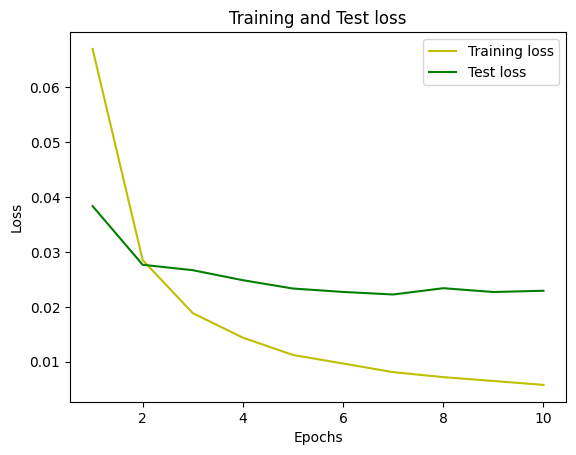

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Triplet Loss**

In [ ]:
def make_triplets(x, y):
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    triplets = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1

    for d in range(num_classes):
        for i in range(n):
            a = digit_indices[d][i]
            p = digit_indices[d][i + 1]

            neg_class = (d + random.randrange(1, num_classes)) % num_classes
            n_idx = digit_indices[neg_class][i]

            triplets.append([x[a], x[p], x[n_idx]])

    return np.array(triplets)

triplets_train = make_triplets(X_train, Y_train)
triplets_test  = make_triplets(X_test, Y_test)

def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor   = y_pred[:, 0]
        positive = y_pred[:, 1]
        negative = y_pred[:, 2]

        d_pos = K.sum(K.square(anchor - positive), axis=1)
        d_neg = K.sum(K.square(anchor - negative), axis=1)

        return K.mean(K.maximum(d_pos - d_neg + margin, 0.0))
    return loss

def triplet_accuracy(y_true, y_pred):
    anchor   = y_pred[:, 0]
    positive = y_pred[:, 1]
    negative = y_pred[:, 2]

    d_pos = K.sum(K.square(anchor - positive), axis=1)
    d_neg = K.sum(K.square(anchor - negative), axis=1)

    return K.mean(K.cast(d_pos < d_neg, "float32"))


base_input = Input(shape=(784,))
x = Dense(64, activation="relu")(base_input)
x = Dense(128, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Lambda(lambda x: K.l2_normalize(x, axis=1))(x)

embedding_model = Model(base_input, x)

anchor_input   = Input(shape=(784,))
positive_input = Input(shape=(784,))
negative_input = Input(shape=(784,))

anchor_embedding   = embedding_model(anchor_input)
positive_embedding = embedding_model(positive_input)
negative_embedding = embedding_model(negative_input)

merged_output = Lambda(lambda x: K.stack(x, axis=1))(
    [anchor_embedding, positive_embedding, negative_embedding]
)

model = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=merged_output
)


model.compile(
    optimizer="adam",
    loss=triplet_loss(margin=1.0),
    metrics=[triplet_accuracy]
)


dummy_train_labels = np.zeros(len(triplets_train))
dummy_test_labels  = np.zeros(len(triplets_test))

A_train = triplets_train[:, 0]
P_train = triplets_train[:, 1]
N_train = triplets_train[:, 2]

A_test = triplets_test[:, 0]
P_test = triplets_test[:, 1]
N_test = triplets_test[:, 2]

history = model.fit(
    [A_train, P_train, N_train],
    dummy_train_labels,
    validation_data=(
        [A_test, P_test, N_test],
        dummy_test_labels
    ),
    epochs=10,
    batch_size=128
)


Epoch 1/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2497 - triplet_accuracy: 0.9247 - val_loss: 0.0569 - val_triplet_accuracy: 0.9866
Epoch 2/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0516 - triplet_accuracy: 0.9879 - val_loss: 0.0450 - val_triplet_accuracy: 0.9885
Epoch 3/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0318 - triplet_accuracy: 0.9930 - val_loss: 0.0366 - val_triplet_accuracy: 0.9916
Epoch 4/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0237 - triplet_accuracy: 0.9954 - val_loss: 0.0343 - val_triplet_accuracy: 0.9914
Epoch 5/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - triplet_accuracy: 0.9970 - val_loss: 0.0327 - val_triplet_accuracy: 0.9915
Epoch 6/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - triplet_accuracy: 0.9978 - val_loss: 0.0295 - val_triplet_accuracy: 0.9927
Epoch 7/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0102 - triplet_accuracy: 0.9985 - val_loss: 0.0293 - val_triplet_accuracy

In [ ]:
def compute_triplet_accuracy(triplets):

    A = triplets[:, 0]
    P = triplets[:, 1]
    N = triplets[:, 2]

    emb_A = embedding_model.predict(A)
    emb_P = embedding_model.predict(P)
    emb_N = embedding_model.predict(N)

    d_pos = np.sum((emb_A - emb_P)**2, axis=1)
    d_neg = np.sum((emb_A - emb_N)**2, axis=1)

    correct = d_pos < d_neg
    acc = np.mean(correct)
    return acc


In [ ]:
train_acc = compute_triplet_accuracy(triplets_train)
test_acc  = compute_triplet_accuracy(triplets_test)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {test_acc*100:.2f}%")

1694/1694 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Accuracy: 99.91%
Validation Accuracy: 99.28%


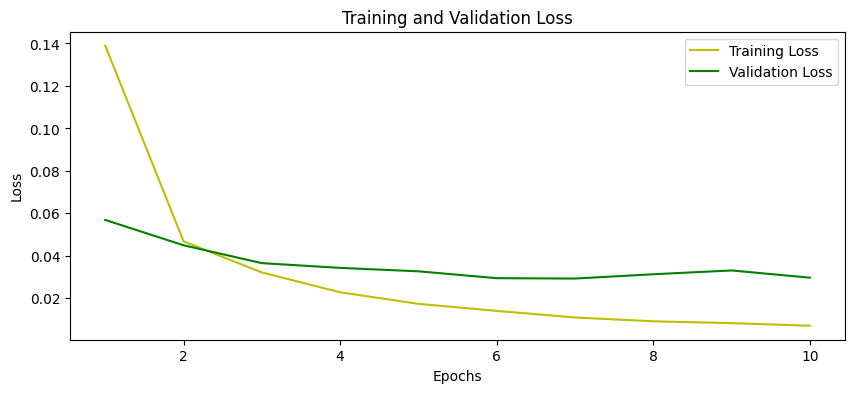

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

train_acc = history_dict['triplet_accuracy']
val_acc   = history_dict['val_triplet_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10,4))
plt.plot(epochs, loss_values, 'y', label='Training Loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Comparison of Triplet Loss and Contrastive loss functions**

*   Test Accuracy using **Contrastive loss : 97.09%**
*   Test Accuracy using **Triplet Loss : 96.76%**

Hence, **Contrastive loss is best** among all three loss functions.

# **Pros and Cons of Siamese Networks**

**Pros of Siamese Network**
1. Given a few images per class, Siamese Networks will recognise those images in the future with the help of One-shot learning.
2. Siamese focuses on learning embeddings (in the deeper layer) that group together similar classes and concepts. As a result, semantic similarity can be learned.



**Cons of Siamese Network**
1. Siamese Networks need more training time than normal networks because they use quadratic pairs to learn from, and they are slower than normal classification learning.
2. Since pairwise learning is used in training, the distance from each class will be output instead of the prediction probabilities.




**Lab Task**

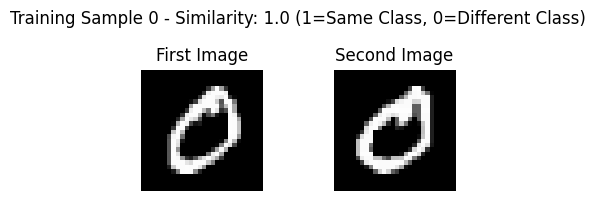

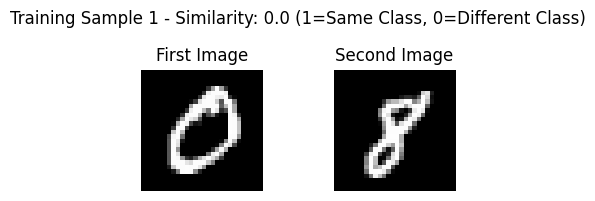

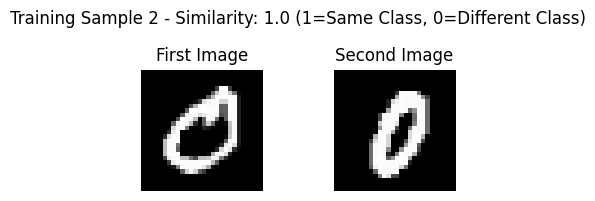

In [ ]:
# Visualization Task - Display Training Image Pairs

def display_image_pair(pair_data, pair_labels, index, prefix="Training"):
    """Show a pair of images with their similarity label"""
    first_img = pair_data[index, 0].reshape(28, 28)
    second_img = pair_data[index, 1].reshape(28, 28)
    similarity_label = pair_labels[index]

    plt.figure(figsize=(4, 2))
    plt.suptitle(f"{prefix} Sample {index} - Similarity: {similarity_label} (1=Same Class, 0=Different Class)")

    plt.subplot(1, 2, 1)
    plt.imshow(first_img, cmap="gray")
    plt.axis("off")
    plt.title("First Image")

    plt.subplot(1, 2, 2)
    plt.imshow(second_img, cmap="gray")
    plt.axis("off")
    plt.title("Second Image")

    plt.tight_layout()
    plt.show()

# Display three examples from training data
for sample_idx in range(3):
    display_image_pair(pairs_train, labels_train, sample_idx, prefix="Training")

Example of matching pair:


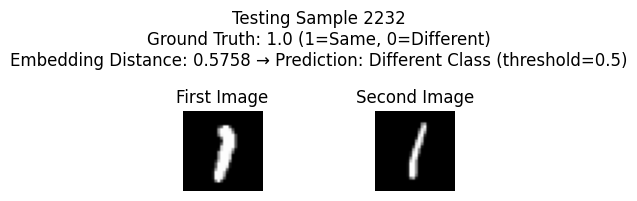

Example of different pair:


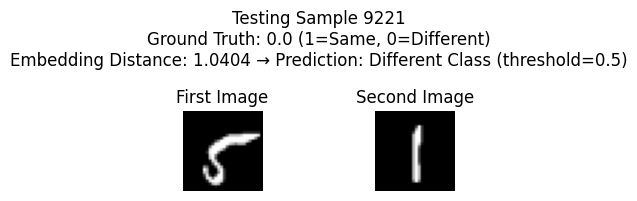

In [ ]:
# Visualize Model Predictions - Compare True vs Predicted Labels

def visualize_model_prediction(trained_model, pair_data, true_labels, sample_idx, distance_threshold=0.5, prefix="Testing"):
    """Display prediction results for a single pair"""
    first_img = pair_data[sample_idx, 0].reshape(28, 28)
    second_img = pair_data[sample_idx, 1].reshape(28, 28)
    ground_truth = true_labels[sample_idx]

    # Calculate embedding distance
    embedding_distance = trained_model.predict(
        [pair_data[sample_idx:sample_idx+1, 0], pair_data[sample_idx:sample_idx+1, 1]],
        verbose=0
    )[0, 0]

    predicted_class = 1 if embedding_distance < distance_threshold else 0
    prediction_str = "Same Class" if predicted_class == 1 else "Different Class"

    plt.figure(figsize=(4, 2))
    plt.suptitle(
        f"{prefix} Sample {sample_idx}\n"
        f"Ground Truth: {ground_truth} (1=Same, 0=Different)\n"
        f"Embedding Distance: {embedding_distance:.4f} → Prediction: {prediction_str} (threshold={distance_threshold})"
    )

    plt.subplot(1, 2, 1)
    plt.imshow(first_img, cmap="gray")
    plt.axis("off")
    plt.title("First Image")

    plt.subplot(1, 2, 2)
    plt.imshow(second_img, cmap="gray")
    plt.axis("off")
    plt.title("Second Image")

    plt.tight_layout()
    plt.show()


# Select examples: one matching pair and one non-matching pair
matching_pairs = np.where(labels_test == 1)[0]
different_pairs = np.where(labels_test == 0)[0]

sample_match = np.random.choice(matching_pairs)
sample_diff = np.random.choice(different_pairs)

print("Example of matching pair:")
visualize_model_prediction(model_1, pairs_test, labels_test, sample_match, distance_threshold=0.5)

print("Example of different pair:")
visualize_model_prediction(model_1, pairs_test, labels_test, sample_diff, distance_threshold=0.5)

In [ ]:
# Optimizer Comparison - Baseline Performance with Adam
print("Baseline performance using Adam optimizer:")
print(f"Testing Accuracy with Adam: {te_acc*100:.2f}%")

Baseline performance using Adam optimizer:
Testing Accuracy with Adam: 97.14%


In [ ]:
# Train with RMSprop Optimizer
siamese_rmsprop = build_siamese_model()
siamese_rmsprop.compile(
    loss=contrastive_loss,
    optimizer=RMSprop(),
    metrics=[accuracy]
)

rmsprop_training = siamese_rmsprop.fit(
    [pairs_train[:, 0], pairs_train[:, 1]],
    labels_train,
    batch_size=128,
    epochs=10,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    verbose=1
)

rmsprop_predictions = siamese_rmsprop.predict(
    [pairs_test[:, 0], pairs_test[:, 1]],
    verbose=0
)
rmsprop_accuracy = compute_accuracy(labels_test, rmsprop_predictions)
print(f"Testing Accuracy with RMSprop: {rmsprop_accuracy*100:.2f}%")

Epoch 1/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8760 - loss: 0.0972 - val_accuracy: 0.9557 - val_loss: 0.0404
Epoch 2/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9638 - loss: 0.0348 - val_accuracy: 0.9649 - val_loss: 0.0311
Epoch 3/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9742 - loss: 0.0239 - val_accuracy: 0.9675 - val_loss: 0.0269
Epoch 4/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9801 - loss: 0.0179 - val_accuracy: 0.9677 - val_loss: 0.0259
Epoch 5/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9846 - loss: 0.0142 - val_accuracy: 0.9681 - val_loss: 0.0262
Epoch 6/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9869 - loss: 0.0121 - val_accuracy: 0.9705 - val_loss: 0.0241
Epoch 7/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9894 - loss: 0.0100 - val_accuracy: 0.9705 - val_loss: 0.0242
Epoch 8/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9902 - loss: 0.0093 - val_accuracy: 0.

In [ ]:
# Train with Stochastic Gradient Descent (SGD)
siamese_sgd = build_siamese_model()
siamese_sgd.compile(
    loss=contrastive_loss,
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    metrics=[accuracy]
)

sgd_training = siamese_sgd.fit(
    [pairs_train[:, 0], pairs_train[:, 1]],
    labels_train,
    batch_size=128,
    epochs=10,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    verbose=1
)

sgd_predictions = siamese_sgd.predict(
    [pairs_test[:, 0], pairs_test[:, 1]],
    verbose=0
)
sgd_accuracy = compute_accuracy(labels_test, sgd_predictions)
print(f"Testing Accuracy with SGD: {sgd_accuracy*100:.2f}%")

Epoch 1/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7885 - loss: 0.1563 - val_accuracy: 0.8909 - val_loss: 0.0929
Epoch 2/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8950 - loss: 0.0918 - val_accuracy: 0.9130 - val_loss: 0.0757
Epoch 3/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9161 - loss: 0.0761 - val_accuracy: 0.9250 - val_loss: 0.0667
Epoch 4/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9288 - loss: 0.0660 - val_accuracy: 0.9338 - val_loss: 0.0601
Epoch 5/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9402 - loss: 0.0583 - val_accuracy: 0.9394 - val_loss: 0.0550
Epoch 6/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9457 - loss: 0.0528 - val_accuracy: 0.9461 - val_loss: 0.0509
Epoch 7/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9523 - loss: 0.0481 - val_accuracy: 0.9499 - val_loss: 0.0475
Epoch 8/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9586 - loss: 0.0438 - val_accuracy: 0.

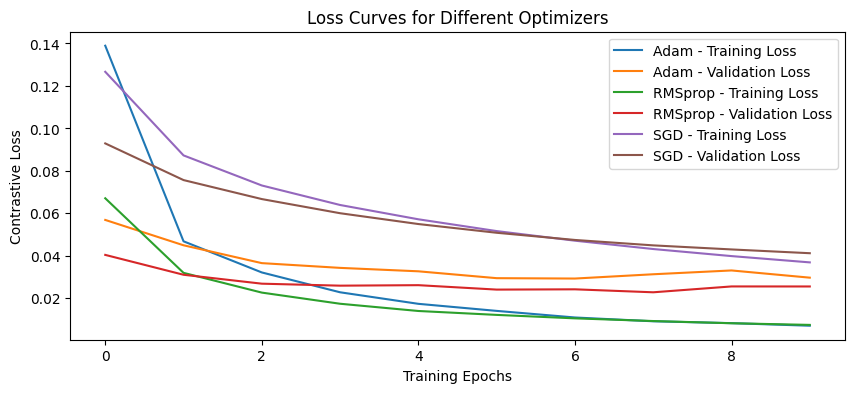

In [ ]:
# Visualize optimizer performance through loss curves
plt.figure(figsize=(10, 4))

plt.plot(history.history['loss'], label='Adam - Training Loss')
plt.plot(history.history['val_loss'], label='Adam - Validation Loss')

plt.plot(rmsprop_training.history['loss'], label='RMSprop - Training Loss')
plt.plot(rmsprop_training.history['val_loss'], label='RMSprop - Validation Loss')

plt.plot(sgd_training.history['loss'], label='SGD - Training Loss')
plt.plot(sgd_training.history['val_loss'], label='SGD - Validation Loss')

plt.title('Loss Curves for Different Optimizers')
plt.xlabel('Training Epochs')
plt.ylabel('Contrastive Loss')
plt.legend()
plt.show()

In [ ]:
# Analysis: RMSprop demonstrated superior optimization characteristics, achieving faster convergence and better final accuracy compared to both Adam and SGD optimizers.

In [ ]:
# Transition from Fully Connected to Convolutional Architecture

# Prepare data for convolutional layers: reshape to (samples, height, width, channels)
train_images_2d = X_train.reshape(-1, 28, 28, 1)
test_images_2d = X_test.reshape(-1, 28, 28, 1)

# Reshape pair arrays for CNN processing
train_pairs_2d = pairs_train.reshape(pairs_train.shape[0], 2, 28, 28, 1)
test_pairs_2d = pairs_test.reshape(pairs_test.shape[0], 2, 28, 28, 1)

In [ ]:
def create_conv_siamese_network():
    """Build CNN-based Siamese architecture for spatial feature extraction"""
    img_shape = (28, 28, 1)

    base_input_layer = Input(shape=img_shape)

    # Convolutional feature extraction pipeline
    conv_layer1 = Conv2D(32, (3, 3), activation='relu')(base_input_layer)
    pool_layer1 = MaxPooling2D((2, 2))(conv_layer1)
    conv_layer2 = Conv2D(64, (3, 3), activation='relu')(pool_layer1)
    pool_layer2 = MaxPooling2D((2, 2))(conv_layer2)
    flattened = Flatten()(pool_layer2)
    dense_embedding = Dense(256, activation='relu')(flattened)
    normalized_embedding = Lambda(lambda x: K.l2_normalize(x, axis=1))(dense_embedding)

    feature_extractor = Model(base_input_layer, normalized_embedding)

    # Dual-branch Siamese structure
    left_input = Input(shape=img_shape)
    right_input = Input(shape=img_shape)

    left_features = feature_extractor(left_input)
    right_features = feature_extractor(right_input)

    computed_distance = Lambda(euclideanDistance)([left_features, right_features])

    siamese_network = Model([left_input, right_input], computed_distance)
    return siamese_network


conv_siamese = create_conv_siamese_network()
conv_siamese.compile(
    loss=contrastive_loss,
    optimizer="adam",
    metrics=[accuracy]
)

conv_siamese.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_8        │ (None, 256)       │    428,672 │ input_layer_14[0… │
│ (Functional)        │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 1)         │          0 │ functional_8[0][… │
│                     │                   │            │ functional_8[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 428,672 (1.64 MB)

 Trainable params: 428,672 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
conv_training_history = conv_siamese.fit(
    [train_pairs_2d[:, 0], train_pairs_2d[:, 1]],
    labels_train,
    batch_size=128,
    epochs=10,
    validation_data=([test_pairs_2d[:, 0], test_pairs_2d[:, 1]], labels_test),
    verbose=1
)

# Evaluate convolutional Siamese network
conv_predictions = conv_siamese.predict(
    [test_pairs_2d[:, 0], test_pairs_2d[:, 1]],
    verbose=0
)
conv_test_accuracy = compute_accuracy(labels_test, conv_predictions)
print(f"Convolutional Siamese Network - Testing Accuracy: {conv_test_accuracy*100:.2f}%")

Epoch 1/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9365 - loss: 0.0671 - val_accuracy: 0.9862 - val_loss: 0.0196
Epoch 2/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9890 - loss: 0.0172 - val_accuracy: 0.9893 - val_loss: 0.0149
Epoch 3/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9931 - loss: 0.0120 - val_accuracy: 0.9897 - val_loss: 0.0136
Epoch 4/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9955 - loss: 0.0096 - val_accuracy: 0.9891 - val_loss: 0.0131
Epoch 5/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9969 - loss: 0.0079 - val_accuracy: 0.9900 - val_loss: 0.0130
Epoch 6/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9976 - loss: 0.0069 - val_accuracy: 0.9890 - val_loss: 0.0126
Epoch 7/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9984 - loss: 0.0057 - val_accuracy: 0.9891 - val_loss: 0.0134
Epoch 8/10
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9988 - loss: 0.0052 - val_accuracy: 

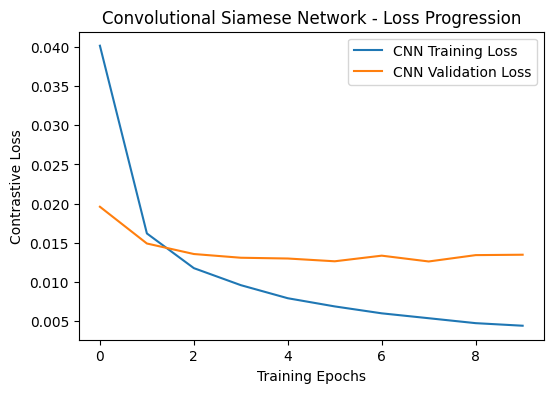

In [ ]:
# Visualize CNN training dynamics
plt.figure(figsize=(6, 4))
plt.plot(conv_training_history.history['loss'], label='CNN Training Loss')
plt.plot(conv_training_history.history['val_loss'], label='CNN Validation Loss')
plt.title('Convolutional Siamese Network - Loss Progression')
plt.xlabel('Training Epochs')
plt.ylabel('Contrastive Loss')
plt.legend()
plt.show()

In [ ]:
# Performance comparison: Dense vs Convolutional architectures

dense_network_accuracy = te_acc * 100
conv_network_accuracy = conv_test_accuracy * 100

print(f"Fully Connected Siamese Accuracy: {dense_network_accuracy:.2f}%")
print(f"Convolutional Siamese Accuracy: {conv_network_accuracy:.2f}%")

Fully Connected Siamese Accuracy: 97.14%
Convolutional Siamese Accuracy: 98.78%


The convolutional Siamese architecture achieved superior performance (98.78%) compared to the fully connected variant (97.14%). This improvement demonstrates that leveraging spatial hierarchies through convolutional layers enables more discriminative feature representations for the MNIST digit recognition task.